In [1]:
%matplotlib qt

In [2]:
import os.path as op
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

import matplotlib

In [11]:
sub_ids = [
            'pre4009_y'
           ]
data_path = '.\data\\1raw_rename\\'

'''

https://mne.discourse.group/t/where-i-can-find-a-montage-for-neuroscan-64ch/4179/3

'''
sub_id = sub_ids[0]
fname = op.join(data_path + sub_id + '.fif')
raw = mne.io.read_raw_fif(fname, preload=True, verbose=None)
# raw.plot_sensors()
# raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,
#                  highpass=0.1, lowpass=30)
# raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)
# raw.plot_sensors()
# raw.plot()
# 这两个channel其实是有用的,但是和模板里名字不一致.
raw.drop_channels(['CB1','CB2', 'Trigger','EKG', 'EMG']) # i dont need those channels
rename_dict = {'HEO': 'HEOG','VEO':'VEOG','FP1':'Fp1', 'FPZ':'Fpz', 'FP2':'Fp2', 'FZ':'Fz', 'FCZ':'FCz', 'CZ':'Cz', 'CPZ':"CPz", 'PZ':"Pz", 'POZ':"POz", 'OZ':"Oz"}
raw.rename_channels(rename_dict)

print(raw.info)

chan_types_dict = { "VEOG":"eog","HEOG":"eog"}
raw.set_channel_types(chan_types_dict)

#电极点位置确定
raw.plot_sensors() # 画出电极位置
locs_info_path = './standard-10-5-cap385.elp'
# montage = mne.channels.read_custom_montage(locs_info_path, head_size=0.095)
montage = mne.channels.make_standard_montage(kind='standard_1005')
# 自带的montage,如果没有montage文件. 如果没有就用mne自带的
# mne.channels.get_builtin_montages()
raw.set_montage(montage)
raw.plot_sensors()# 对比一下 montage之后的位置
plt.show() # 只呈现一次


Opening raw data file .\data\1raw_rename\pre4009_y.fif...


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_20660\425437293.py:13: RuntimeWarning: This filename (.\data\1raw_rename\pre4009_y.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True, verbose=None)


    Range : 0 ... 5077899 =      0.000 ...  5077.899 secs
Ready.
Reading 0 ... 5077899  =      0.000 ...  5077.899 secs...
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 72 items (3 Cardinal, 69 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 2 items (dict)
>


In [ ]:
raw  = raw.copy().crop(tmin=1000, tmax=3500)

In [17]:
raw.annotations.onset = raw.annotations.onset - 1000

In [5]:
#找出坏导
%matplotlib qt
# raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,
#                  highpass=0.1, lowpass=30)
raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)


Using qt as 2D backend.


In [6]:
print(raw.info['bads'])
save_path_bad = '.\data\\2raw_bad\\'
raw.save(save_path_bad + sub_id + '.fif', overwrite=True)

[]
Overwriting existing file.
Writing E:\实验\阅读困难\数据处理\pre4\data\2raw_bad\pre4009_y.fif


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_20660\681947393.py:3: RuntimeWarning: This filename (E:\实验\阅读困难\数据处理\pre4\data\2raw_bad\pre4009_y.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path_bad + sub_id + '.fif', overwrite=True)


Closing E:\实验\阅读困难\数据处理\pre4\data\2raw_bad\pre4009_y.fif
[done]


In [7]:
#插值
original_bads = deepcopy(raw.info['bads'])
print(raw.info['bads'])
#截取一部分作图
# raw.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)
# How interpolation works¶根据手册，是根据topo位置来插值？所以需要location
raw_interp = raw.copy().interpolate_bads(reset_bads=True)
print(raw.info['bads'])
# raw_interp.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6, remove_dc = True,highpass=1,lowpass=40)

#滤波
# raw_interp.copy().plot_psd(area_mode='range', average=False)
# 要做时频分析，上限高一点？脑干 80
# 不同数据对这个要求不一样,这里稍微设置高一点,后面再各自处理好了.
raw_middlepass = raw_interp.copy().filter(0.1, 40.)
sample_rate=500
freqs = np.arange(50, sample_rate / 2, 50)
raw_middlepass_notch = raw_middlepass.copy().notch_filter(freqs=freqs)
# raw_middlepass_notch.copy().plot_psd(area_mode='range', average=False)


[]


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_20660\154905464.py:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_interp = raw.copy().interpolate_bads(reset_bads=True)


[]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   10.1s finished


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    5.4s finished


In [9]:
#重参考
#需要搞清楚到底有没有把eog channel一起算进去。
# raw_middlepass_notch.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)
raw_rerefer = raw_middlepass_notch.copy().set_eeg_reference(ref_channels='average')
# raw_rerefer.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)

#保存,在ICA之前
# print(raw_rerefer.info['custom_ref_app|ied'])
save_path_bad = '.\data\\3raw_rereference\\'
raw_rerefer.save(save_path_bad + sub_id + '.fif', overwrite=True)
raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)
from mne.preprocessing import annotate_movement, compute_average_dev_head_t,annotate_muscle_zscore

# 之所以改成66s,是因为长 4hz的ASSR是65s一个试次
break_annots = mne.preprocessing.annotate_break(raw_rerefer,min_break_duration=20,)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Overwriting existing file.
Writing E:\实验\阅读困难\数据处理\pre4\data\3raw_rereference\pre4009_y.fif


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_20660\634426242.py:10: RuntimeWarning: This filename (E:\实验\阅读困难\数据处理\pre4\data\3raw_rereference\pre4009_y.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_rerefer.save(save_path_bad + sub_id + '.fif', overwrite=True)


Closing E:\实验\阅读困难\数据处理\pre4\data\3raw_rereference\pre4009_y.fif
[done]
Ignoring annotations with descriptions starting with: bad, edge

Detected 5 break periods of >= 20 sec duration:
    0.0 – 87.1 sec [87.1 sec]
    672.2 – 1049.6 sec [377.4 sec]
    1059.6 – 1173.7 sec [114.1 sec]
    1761.8 – 1844.9 sec [83.1 sec]
    2430.5 – 2500.0 sec [69.5 sec]
In total, 29.3% of the data (731.3 sec) have been marked as a break.



In [18]:
# raw_rerefer.set_annotations(raw_rerefer.annotations + break_annots)

raw_rerefer.set_annotations(annotations=raw.annotations + break_annots)
raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6)


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_20660\3671617625.py:3: RuntimeWarning: Omitted 880 annotation(s) that were outside data range.
  raw_rerefer.set_annotations(annotations=raw.annotations + break_annots)


In [ ]:
# 根据amplitude标注一次
amp_annots = mne.preprocessing.annotate_amplitude(raw_rerefer, peak=40e-6, min_duration=1)[0]
# 在原有基础上加上amp_annots
raw_rerefer.set_annotations(raw_rerefer.annotations+amp_annots)
raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6)

# 根据头动标注一次 movement
# https://mne.tools/stable/auto_examples/preprocessing/movement_detection.html#sphx-glr-auto-examples-preprocessing-movement-detection-py

# Get cHPI time series and compute average
# chpi_locs = mne.chpi.extract_chpi_locs_ctf(raw_rerefer)
# head_pos = mne.chpi.compute_head_pos(raw.info, chpi_locs)
# mean_distance_limit = .0015  # in meters
# annotation_movement, hpi_disp = annotate_movement(
#     raw_rerefer, head_pos, mean_distance_limit=mean_distance_limit)
# raw_rerefer.set_annotations(raw_rerefer.annotations+annotation_movement)
# raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6)


# 根据 动作 标注一次 muscle
# The threshold is data dependent, check the optimal threshold by plotting
# ``scores_muscle``.
threshold_muscle = 5  # z-score
# Choose one channel type, if there are axial gradiometers and magnetometers,
# select magnetometers as they are more sensitive to muscle activity.
annot_muscle, scores_muscle = annotate_muscle_zscore(
    raw, ch_type="eeg", threshold=threshold_muscle, min_length_good=0.1,
    filter_freq=[110, 140])
raw_rerefer.set_annotations(raw_rerefer.annotations + annot_muscle)
raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6)

Finding segments below or above PTP threshold.


In [ ]:
'''
问题，不知道ICA到底有没有吧 break计算上。
'''
import time
time_start=time.time()
# ICA
raw_filt = raw_rerefer.copy()
raw_filt.load_data().filter(l_freq=0.1, h_freq= 40)
# 有一段数据非常糟糕,而且是有mark的部分,所以直接截掉,而不是用break来标记
# raw_filt.crop(tmin=132)
raw_filt.plot(n_channels = 50, duration =40, scalings=60e-6)

In [ ]:
ica = ICA(n_components=30, random_state=97, )
#训练，但是并没有删除
ica.fit(raw_filt)
#计时
time_end=time.time()
print('time cost',time_end-time_start,'s')
print(sub_id)

In [20]:
#有多种选择，自动，手动。找出eog component
# eog_inds, eog_scores = ica.find_bads_eog(raw_filt, threshold=3.0, ch_name='Fp2')#0 7数据眼电有问题
eog_inds, eog_scores = ica.find_bads_eog(raw_filt, threshold='auto') # 用3是因为并不是真的那么准确,你需要人为判断.如果改成2,,可能会自动排除许多component.


Using EOG channels: HEOG, VEOG
Omitting 330099 of 910001 (36.27%) samples, retaining 579902 (63.73%) samples.
Omitting 330099 of 910001 (36.27%) samples, retaining 579902 (63.73%) samples.
Omitting 330099 of 910001 (36.27%) samples, retaining 579902 (63.73%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 330099 of 910001 (36.27%) samples, retaining 579902 (63.73%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


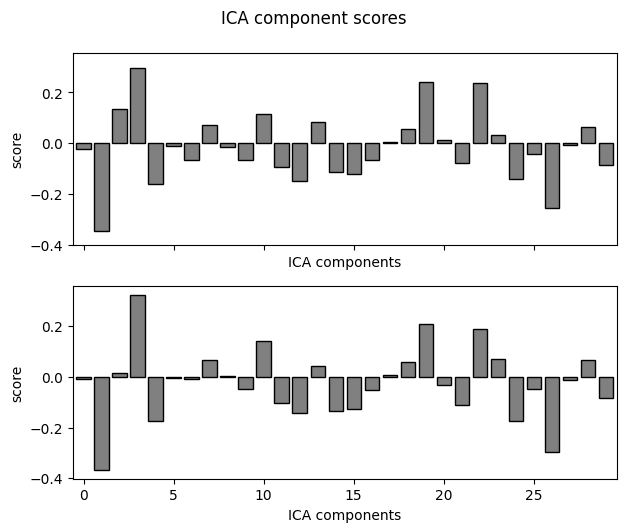

In [21]:
#参考一下机器
ica.plot_scores(eog_scores)
#但是要自己检查一下,有问题就手动修改eog_ins

In [ ]:
ica.plot_components(inst=raw_filt)  #一跑就卡死


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated


In [ ]:

# 手动
eog_inds = [1,3]

In [ ]:
#eog_inds = [0,1]
ica.exclude = eog_inds
ica.plot_scores(eog_scores)
#这个……在filt_raw训练出来的model，可以直接给别的数据用。。
reconst_raw =raw_filt.copy()
reconst_raw.plot(n_channels = 50, duration =40, scalings=40e-6)
ica.apply(reconst_raw)
reconst_raw.plot(n_channels = 50, duration =40, scalings=40e-6)

In [16]:
#确认无误，保存一下,raw ica
save_path_ica = '.\data\\4raw_ica\\'
ica.save(save_path_ica + sub_id + '.fiff', overwrite=True)
reconst_raw.save(save_path_ica + sub_id + '.fif', overwrite=True)

Writing ICA solution to E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4005_a.fiff...
Writing E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4005_a.fif


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_13056\1712641093.py:3: RuntimeWarning: This filename (.\data\4raw_ica\pre4005_a.fiff) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(save_path_ica + sub_id + '.fiff', overwrite=True)
C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_13056\1712641093.py:4: RuntimeWarning: This filename (E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4005_a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw.save(save_path_ica + sub_id + '.fif', overwrite=True)


Closing E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4005_a.fif
[done]


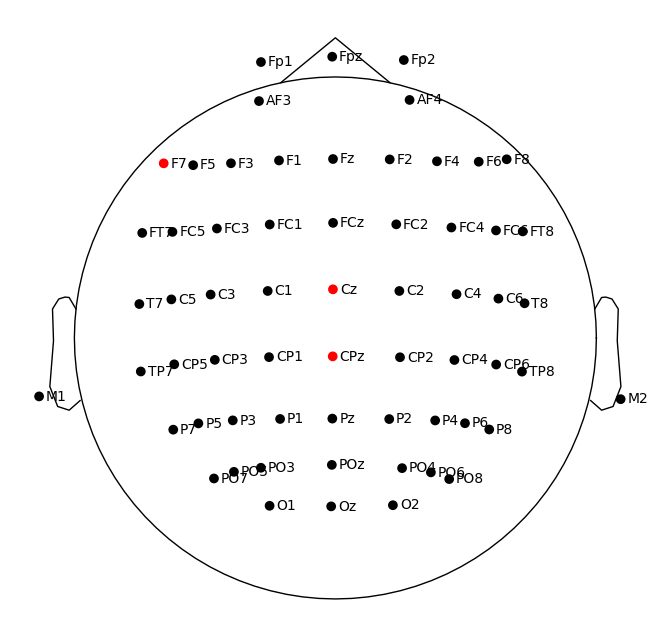

In [71]:
'''
脑区域图。

'''
raw.plot_sensors(show_names=True)